In [1]:
import deap
import random
import numpy as np
from deap import base
from deap import creator
from deap import algorithms
from deap import tools
from deap import gp
import operator
import math
random.seed(3)

In [2]:
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))

In [3]:
pset.renameArguments(ARG0='x')

In [4]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [5]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

def evalSymbReg(individual, points):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    # Evaluate the mean squared error between the expression
    # and the real function : x**4 + x**3 + x**2 + x
    sqerrors = ((func(x) - y)**2 for x, y in points)
    return math.fsum(sqerrors) / len(points),

toolbox.register("evaluate", evalSymbReg, points=[(-2.00,37.00000),
 (-1.75,24.16016),
 (-1.50,15.06250),
 (-1.25, 8.91016),
 (-1.00, 5.00000),
 (-0.75, 2.72266),
 (-0.50, 1.56250),
 (-0.25, 1.09766),
 ( 0.00, 1.00000),
 ( 0.25, 1.03516),
 ( 0.50, 1.06250),
 ( 0.75, 1.03516),
 ( 1.00, 1.00000),
 ( 1.25, 1.09766),
 ( 1.50, 1.56250),
 ( 1.75, 2.72266),
 ( 2.00, 5.00000),
 ( 2.25, 8.91016),
 ( 2.50,15.06250),
 ( 2.75,24.16016)])
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [6]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)
pop = toolbox.population(n=500)
hof = tools.HallOfFame(1)
pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 40, stats=mstats,
                       halloffame=hof, verbose=True)

   	      	                    fitness                    	                     size                     
   	      	-----------------------------------------------	----------------------------------------------
gen	nevals	avg    	gen	max    	min    	nevals	std    	avg  	gen	max	min	nevals	std   
0  	500   	161.061	0  	252.831	59.7201	500   	17.6029	3.646	0  	7  	2  	500   	1.5168
1  	270   	151.387	1  	234.262	59.7201	270   	19.818 	3.814	1  	10 	1  	270   	1.72841
2  	279   	145.017	2  	232.991	59.7201	279   	22.5181	4.156	2  	15 	1  	279   	1.90464
3  	264   	137.92 	3  	352.039	59.7201	264   	28.7806	4.534	3  	15 	1  	264   	2.06709
4  	291   	123.94 	4  	650.343	27.9965	291   	39.2251	4.8  	4  	12 	1  	291   	1.92977
5  	239   	105.294	5  	326.248	27.9965	239   	34.4416	4.99 	5  	13 	1  	239   	1.86277
6  	270   	93.3748	6  	674.021	13.7879	270   	52.5488	5.888	6  	14 	1  	270   	2.04143
7  	277   	79.8637	7  	981.22 	13.7879	277   	54.3208	6.822	7  	15 	1  	277   	2.23927
8  	299

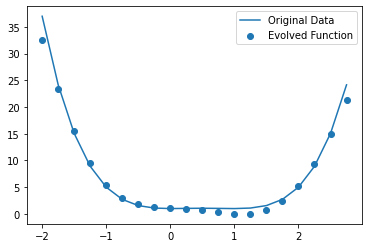

In [7]:
best_individual = tools.selBest(pop, k=1)[0]
expr = best_individual
best_program = toolbox.compile(expr=best_individual)
nodes, edges, labels = gp.graph(expr)
import matplotlib.pyplot as plt
plt.plot([-2.0, -1.75, -1.50, -1.25, -1.00, -0.75, -0.50, -0.25, 0.00, 0.25, 
         0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50, 2.75], [37.0000, 
        24.1602 ,15.0625, 8.9102, 5.0000, 2.7227, 1.5625, 1.0977, 1.0000, 1.0352,
        1.0625, 1.0352, 1.0000, 1.0977, 1.5625, 2.7227, 5.0000, 8.9102, 15.0625, 24.1602])
plt.scatter([-2.0, -1.75, -1.50, -1.25, -1.00, -0.75, -0.50, -0.25, 0.00, 0.25, 
         0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50, 2.75], [best_program(-2.0), 
        best_program(-1.75), best_program(-1.50), best_program(-1.25), best_program(-1.00), 
        best_program(-0.75), best_program(-0.50), best_program(-0.25), best_program(0.00), 
        best_program(0.25), best_program(0.50), best_program(0.75), best_program(1.00), 
        best_program(1.25), best_program(1.50), best_program(1.75), best_program(2.00), 
        best_program(2.25), best_program(2.50), best_program(2.75)])
plt.legend(['Original Data', 'Evolved Function'])
plt.show()

In [8]:
import pygraphviz as pgv
g = pgv.AGraph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
g.layout(prog="dot")

for i in nodes:
    n = g.get_node(i)
    n.attr["label"] = labels[i]

g.draw("tree3.pdf")

In [9]:
print(str(expr.fitness))

(1.703299185511669,)


In [11]:
print(str(best_individual))

mul(add(-1, x), add(add(add(sub(add(-1, x), sin(x)), sub(sub(add(-1, x), sin(add(add(sub(-1, sin(x)), x), x))), sin(x))), add(x, add(sub(sub(0, sin(add(add(sin(sin(0)), x), x))), sin(x)), x))), x))
